In [1]:
%load_ext autoreload
%autoreload 2

### Load libraries and paths

In [2]:
import sys
sys.path.append("../../")

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import pymc as pm 

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score

from config.config import BASE_PATH, PATH_TO_PATH_CONFIG_FILE, PROJECT_EPSG
from src.utils import load_paths_from_yaml, replace_base_path
from src.modeling.encodings import convert_aspect_to_cardinal_direction, convert_population_to_classes, convert_elevation_to_classes, convert_slope_to_classes, apply_encoding, naturraumregionen_encoding, map_to_binary
from src.modeling.utils import temporal_train_test_split
from src.modeling.bayesian_models import create_blr_v2, create_st_blr_v2, create_bnn, create_st_intercept_blr_v2
from src.modeling.predictions import BinaryClassification, BinaryClassificationBNN

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
paths = load_paths_from_yaml(PATH_TO_PATH_CONFIG_FILE)
paths = replace_base_path(paths, BASE_PATH)

### Read in data

In [5]:
# read in training data
training_data = gpd.read_file(paths["training_data"])
training_data.date = pd.to_datetime(training_data.date)

# read in Naturraumregionen
naturraumregionen = gpd.read_file(paths["naturraumregionen"])
naturraumregionen.to_crs(PROJECT_EPSG, inplace=True)

### Data Cleaning & Preparation

In [6]:
# rename columns
training_data.rename(columns={"farmyard_d": "farmyard_density", 
                              "hiking_ds": "hikingtrail_density", 
                              "forest_ds": "forestroad_density", 
                              "rail_dens": "railway_density", 
                              "foresttype": "forest_type", 
                              "pop_dens": "population_density"}, inplace=True)

training_data = training_data.sjoin(naturraumregionen.loc[:, ["EINHEIT", "geometry"]])
training_data.drop(columns=["index_right"], inplace=True)

# create season column (0 = winter (1,2,3), 1 = spring (4,5,6), 2 = sommer (7,8,9), 3 = winter (10,11,12))
training_data["season"] = (training_data.date.dt.month -1) // 3 

# encode features into predefined classes
training_data["naturraumregionen_encoded"] = training_data["EINHEIT"].apply(apply_encoding, mapping=naturraumregionen_encoding)
training_data["elevation_encoded"] = training_data["elevation"].apply(convert_elevation_to_classes)
training_data["slope_encoded"] = training_data["slope"].apply(convert_slope_to_classes)
training_data["aspect_encoded"] = training_data["aspect"].apply(convert_aspect_to_cardinal_direction)
training_data["population_encoded"] = training_data["population_density"].apply(convert_population_to_classes)

# binarize features
training_data["farmyard_density_bin"] = training_data["farmyard_density"].apply(map_to_binary)
training_data["forestroad_density_bin"] = training_data["forestroad_density"].apply(map_to_binary)
training_data["railway_density_bin"] = training_data["railway_density"].apply(map_to_binary)
training_data["hikingtrail_density_bin"] = training_data["hikingtrail_density"].apply(map_to_binary)

# deal with missing data in forest type feature
training_data["forest_type"].fillna(6, inplace=True)
training_data["forest_type"] = training_data["forest_type"].astype(int)

### Temporal train test split

In [17]:
X_train_unprocessed, X_test_unprocessed = temporal_train_test_split(training_data, "date", 0.7)
y_train, y_test = X_train_unprocessed["fire"], X_test_unprocessed["fire"]

print("The following gives us the split date:")
print(X_train_unprocessed.date.max())
print(X_test_unprocessed.date.min())

The following gives us the split date:
2016-05-09 00:00:00
2016-05-11 00:00:00


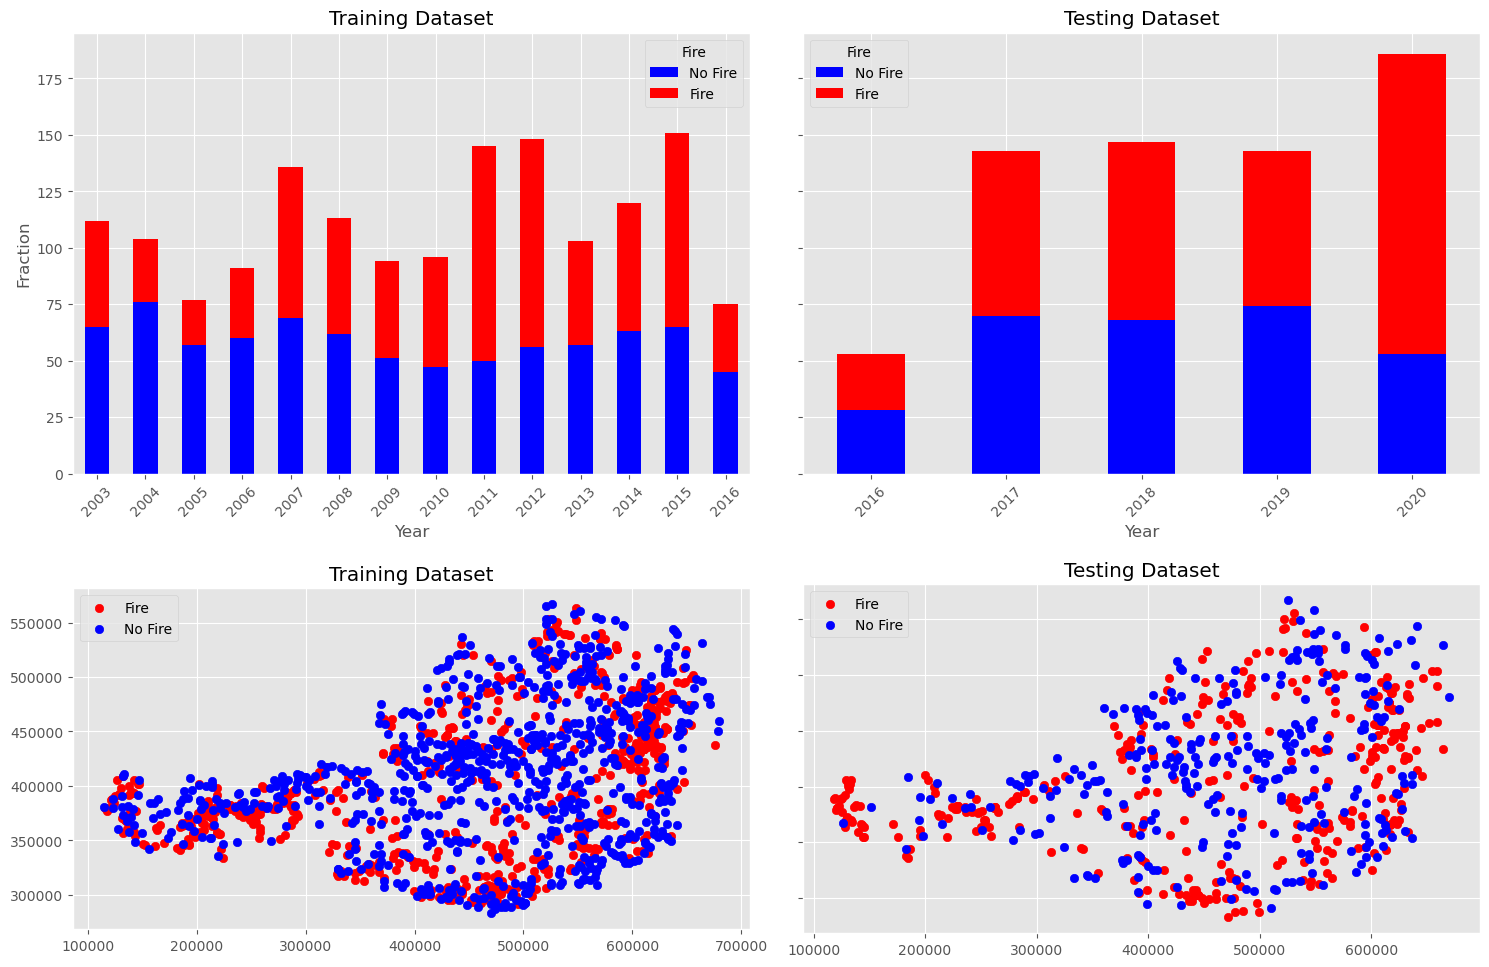

In [16]:
# Plotting the distribution of fire and no-fire samples for train and test set

fractions_train = X_train_unprocessed.groupby("year").fire.value_counts().unstack()
fractions_test = X_test_unprocessed.groupby("year").fire.value_counts().unstack()

plt.style.use('ggplot')
fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharey="row")

# Plot for training dataset
fractions_train.plot(kind='bar', stacked=True, ax=axs[0][0], color=["blue", "red"])
axs[0][0].set_xlabel('Year')
axs[0][0].set_ylabel('Fraction')
axs[0][0].set_title('Training Dataset')
axs[0][0].legend(title='Fire', labels=['No Fire', 'Fire'])
axs[0][0].tick_params(axis='x', rotation=45)

# Plot for testing dataset
fractions_test.plot(kind='bar', stacked=True, ax=axs[0][1], color=["blue", "red"])
axs[0][1].set_xlabel('Year')
axs[0][1].set_ylabel('Fraction')
axs[0][1].set_title('Testing Dataset')
axs[0][1].legend(title='Fire', labels=['No Fire', 'Fire'])
axs[0][1].tick_params(axis='x', rotation=45)


# Create two separate GeoDataFrames for fire and no fire in training dataset
gdf_fire_train = X_train_unprocessed[X_train_unprocessed['fire'] == 1]
gdf_no_fire_train = X_train_unprocessed[X_train_unprocessed['fire'] == 0]

# Create two separate GeoDataFrames for fire and no fire in testing dataset
gdf_fire_test = X_test_unprocessed[X_test_unprocessed['fire'] == 1]
gdf_no_fire_test = X_test_unprocessed[X_test_unprocessed['fire'] == 0]

# Plot for training dataset
axs[1][0].set_title('Training Dataset')
gdf_fire_train.plot(ax=axs[1][0], color='red', label='Fire')
gdf_no_fire_train.plot(ax=axs[1][0], color='blue', label='No Fire')

# Plot for testing dataset
axs[1][1].set_title('Testing Dataset')
gdf_fire_test.plot(ax=axs[1][1], color='red', label='Fire')
gdf_no_fire_test.plot(ax=axs[1][1], color='blue', label='No Fire')

# Add legends
axs[1][0].legend()
axs[1][1].legend()

plt.tight_layout()
plt.savefig(r"C:\Users\b1105474\OneDrive - Universität Salzburg\PR_IGNITE\IGNITE_david\documentation\images\train_test_distribution.png")
plt.show()


### Feature Preprocessing

In [25]:
# feature processing for BLR and ST_BLR
preprocessor_blr = ColumnTransformer(
    transformers=[
        ('std_scaler', StandardScaler(), ["ffmc"])
    ],
    remainder='drop',
)

preprocessor_blr.fit(X_train_unprocessed)
train_ffmc_scaled = preprocessor_blr.transform(X_train_unprocessed)
test_ffmc_scaled = preprocessor_blr.transform(X_test_unprocessed)

X_train = X_train_unprocessed.copy()
X_test = X_test_unprocessed.copy()
X_train["ffmc"] = train_ffmc_scaled
X_test["ffmc"] = test_ffmc_scaled

# feature processing for BNN
features_to_scale = ['ffmc', 'farmyard_density',
       'hikingtrail_density', 'forestroad_density', 'railway_density',
       'elevation', 'slope', 'population_density']
features_bnn_ohe = ['aspect_encoded', 'forest_type']

preprocessor_bnn = ColumnTransformer(
    transformers=[
        ('std_scaler', StandardScaler(), features_to_scale),
        ('ohe', OneHotEncoder(), features_bnn_ohe)
    ],
    remainder='drop',
)

# scaler
preprocessor_bnn.fit(X_train_unprocessed)
X_train_bnn = preprocessor_bnn.fit_transform(X_train_unprocessed)
X_test_bnn = preprocessor_bnn.transform(X_test_unprocessed)

### Modeling

In [26]:
coords = {"elevation_classes": [0, 1, 2, 3, 4, 5], 
          "slope_classes": [0, 1, 2, 3, 4], 
          "aspect_classes": [0, 1, 2, 3, 4, 5, 6, 7],
          "forest_type_classes": [0, 1, 2, 3, 4, 5, 6], 
          "population_classes": [0, 1, 2, 3, 4, 5], 
          "farmyard_density_classes": [0, 1], 
          "forestroad_density_classes": [0, 1], 
          "railway_density_classes": [0, 1], 
          "hikingtrail_density_classes": [0, 1], 
          "spatial_groups": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 
          "temporal_groups": [0, 1, 2, 3]}

In [27]:
# Create simple Bayesian Log Reg Model
model_blr = create_blr_v2(X_train, y_train, coords)
with model_blr:
    approx = pm.fit(n=20000, random_seed=0)
    blr_idata = approx.sample()
    pm.compute_log_likelihood(blr_idata)

Finished [100%]: Average Loss = 786.51


In [28]:
model_st_intercept_blr = create_st_intercept_blr_v2(X_train, y_train, coords, "naturraumregionen_encoded", "season")
with model_st_intercept_blr:
    approx = pm.fit(n=20000, random_seed=0)
    st_intercept_blr_idata = approx.sample()
    pm.compute_log_likelihood(st_intercept_blr_idata)

Finished [100%]: Average Loss = 779.44


In [36]:
# Spatio temporal Bayesian Logistic Regression Model
model_st_blr = create_st_blr_v2(X_train, y_train, coords, "naturraumregionen_encoded", "season")
with model_st_blr:
    approx = pm.fit(n=20000, random_seed=0)
    st_blr_idata = approx.sample()
    pm.compute_log_likelihood(st_blr_idata)

Finished [100%]: Average Loss = 1,231.4


In [30]:
model_bnn = create_bnn(X_train_bnn, y_train)

with model_bnn:
    approx = pm.fit(n=20000, random_seed=0)
    bnn_idata = approx.sample()

Finished [100%]: Average Loss = 797.95


### Out-of-sample prediction

In [37]:
y_dummy = [0 for i in y_test]
X_new_blr = {
    "elevation": X_test.elevation_encoded,
    "slope": X_test.slope_encoded,
    "aspect": X_test.aspect_encoded,
    "forestroad_density": X_test.forestroad_density_bin,
    "railway_density": X_test.railway_density_bin,
    "hikingtrail_density": X_test.hikingtrail_density_bin,
    "farmyard_density": X_test.farmyard_density_bin,
    "population": X_test.population_encoded,
    "forest_type": X_test.forest_type,
    "ffmc": X_test.ffmc,
    "fire": y_dummy
    }

X_new_st_blr = X_new_blr.copy()
X_new_st_blr["spatial_groups_idx"] = X_test.naturraumregionen_encoded
X_new_st_blr["temporal_groups_idx"] = X_test.season

In [38]:
seed = 0

# predictions for blr model
blr_prediction_obj = BinaryClassification(model_blr, blr_idata, X_new_blr, seed, "y_pred", "p")
blr_prediction_obj.extend_trace()
blr_preds = blr_prediction_obj.predict()

# predictions for st_intercept_blr model
st_intercept_blr_prediction_obj = BinaryClassification(model_st_intercept_blr, st_intercept_blr_idata, X_new_st_blr, seed, "y_pred", "p")
st_intercept_blr_prediction_obj.extend_trace()
st_intercept_blr_preds = st_intercept_blr_prediction_obj.predict()

# predictions for st_blr model
st_blr_prediction_obj = BinaryClassification(model_st_blr, st_blr_idata, X_new_st_blr, seed, "y_pred", "p")
st_blr_prediction_obj.extend_trace()
st_blr_preds = st_blr_prediction_obj.predict()

# predictions for bnn model
bnn_prediction_obj = BinaryClassificationBNN(model_bnn, bnn_idata, X_test_bnn, seed, "y_pred", "p")
bnn_prediction_obj.extend_trace()
bnn_preds = bnn_prediction_obj.predict()

print("BLR Accuracy: ", accuracy_score(y_test, blr_preds.y_pred))
print("BLR Precision: ", precision_score(y_test, blr_preds.y_pred))
print("BLR Recall: ", recall_score(y_test, blr_preds.y_pred))

print("---------------------------------")

print("ST Intercept BLR Accuracy: ", accuracy_score(y_test, st_intercept_blr_preds.y_pred))
print("ST Intercept BLR Precision: ", precision_score(y_test, st_intercept_blr_preds.y_pred))
print("ST Intercept BLR Recall: ", recall_score(y_test, st_intercept_blr_preds.y_pred))

print("---------------------------------")

print("ST BLR Accuracy: ", accuracy_score(y_test, st_blr_preds.y_pred))
print("ST BLR Precision: ", precision_score(y_test, st_blr_preds.y_pred))
print("ST BLR Recall: ", recall_score(y_test, st_blr_preds.y_pred))

print("---------------------------------")

print("BNN Accuracy: ", accuracy_score(y_test, bnn_preds.y_pred))
print("BNN Precision: ", precision_score(y_test, bnn_preds.y_pred))
print("BNN Recall: ", recall_score(y_test, bnn_preds.y_pred))



Sampling: [y_pred]


Sampling: [y_pred]


Sampling: [y_pred]


Sampling: [y_pred]


BLR Accuracy:  0.7708333333333334
BLR Precision:  0.8279883381924198
BLR Recall:  0.7493403693931399
---------------------------------
ST Intercept BLR Accuracy:  0.7797619047619048
ST Intercept BLR Precision:  0.8387096774193549
ST Intercept BLR Recall:  0.7546174142480211
---------------------------------
ST BLR Accuracy:  0.7485119047619048
ST BLR Precision:  0.7949438202247191
ST BLR Recall:  0.7467018469656992
---------------------------------
BNN Accuracy:  0.7589285714285714
BNN Precision:  0.7924528301886793
BNN Recall:  0.7757255936675461


### Coefficient Analysis

### Performance Evaluation on Spatio-temporal Subroups